# Projet : Apprentissage pour une robotique autonome
# <i>Génération et prédiction de fichier midi</i>

## Introduction

Ce projet s'inscrit dans le cadre du module "Apprentissage pour une robotique autonome" de la spécialisation robotique de l'ENSEIRB-MATMECA et de l'ENSC. 

## Sujet du projet

L'objectif de ce projet est de prédire et générer des fichiers midi à partir d'un corpus choisi de fichiers midi.
Ces fichiers, utilisés pour l'apprentissage, sont joués par un instrument unique et sans accord.

Deux sous-tâches de prédiction/génération peuvent être distinguées :
<ul><li> la prédiction/génération sur la hauteur des notes (pitch)</li>
    <li> la prédiction/génération sur la durée des notes (rythmique)</li>
</ul>


## Réalisation

Ci-dessous le code commenté permettant la génération des fichiers midi :

### Importation des librairies nécessaires

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, MidiTrack, Message, MetaMessage
from scipy import linalg
from ipywidgets import *
from IPython.display import *
import os

#Pour afficher les courbes dans le notebook
%matplotlib inline

### Récupération des données

Le corpus de données contient des fichiers midi de musique classique. 
Afin de s'assurer que les notes sont bien jouées une à la fois, le corpus est constité uniquement de morceaux de flûte (instrument pour lequel on ne peut réaliser d'accord). Les fichiers du corpus utilisé sont présents dans le dossier <i>midi-classique-flute</i>.

On récupère ainsi la hauteur et la durée de chaque note (note_on).
Le jeu de données ainsi récupéré est stocké dans la liste <b>noteon</b>, dont les composants sont des tuples comportant en premier élément la valeur de la hauteur de la note, et en second sa durée.

In [106]:
noteon = []
note=[]
duree=[]
musiclist = os.listdir('midi-classique-flute')

#importation du fichier midi désiré
for musicfile in musiclist:
    mid = MidiFile('midi-classique-flute/[Free-scores.com]_ali-choobdar-night-the-lotus-66972.midi')
    #newfile = 'midi-classique-flute/' + musicfile
    #print(newfile)
    mid = MidiFile(newfile)
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type == 'note_on':
                newNote = (msg.note,msg.time)
                #on ajoute chaque note dans le tableau noteon (hauteur + durée)
                noteon.append(newNote)
                note.append(msg.note)
                duree.append(msg.time)
print(len(noteon))


3528


### Initialisation de l'aléatoire et définition du réseau

#### Initialisation pseudo-aléatoire

La fonction <b>set_seed</b> permet de générant une valeur pseudo-aléatoire qui assure que le lancement à plusieurs reprises de l'apprentissage du réseau ne conduise pas au même résultat.

In [107]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

3291676195
Seed used for random values: 3291676195


#### Classe du réseau
On définit ici la classe du réseau :

In [ ]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        # données d'entrée :
        self.input_text = noteon #The one to keep
        self.resSize = 300
        self.a = 0.3
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.reg =  1e-8
        self.mode = 'prediction'
        seed = None #42
        set_seed(seed)
        
nw = Network()

#### Description de la classe issue de [neuronalX/Reservoir-Jupyter](https://github.com/neuronalX/Reservoir-Jupyter/blob/master/Minimal_ESN_-_FR.ipynb)

Une instance de cette classe contiendra les paramètres modifiables suivants :

<ul><li>initLen : nombre d'itérations pour l'initalisation. Durant cette phase, il ne se passe rien : cela permet de commencer l'entraînement avec une valeur intermédiaire plutôt qu'avec une des premières valeurs des données ;</li>
    <li>trainLen : nombre d'itérations pour l'entraînement. Le réseau va modifier les poids entre le réservoir et la sortie de façon à pouvoir prédire ou générer une série ;</li>
    <li>testLen : nombre d'itérations pour le test ;</li>
    <li>data : fichier de données. Le fichier proposé ici contient les 10 000 premières itérations d'une série chaotique de Mackey-Glass. Une série chaotique est une suite issue d'une fonction, pour laquelle une modification minime du nombre de départ a des conséquences importantes sur les termes suivants.</li>
    
<p style="text-align:justify">De base, notre réservoir contient 300 neurones (<b>resSize</b>), l'entrée et la sortie sont de taille 1 (<b>inSize et outSize</b>). Cela nous donne un réseau sous cette forme : <img src="Reservoir.png"/>

Les neurones en entrée sont connectés aux neurones du réservoir. On représente donc les poids de chacune des connexions par une matrice <b style="color:#99cc00">W<sub>in</sub></b> (de taille inSize × resSize). De même, les connexions des neurones de la sortie sont représentées par la matrice <b style="color:#ff0000">W<sub>out</sub></b> (de taille resSize × outSize). Enfin, dans le réservoir, chaque neurone est lié à tous les autres neurones du réservoir (matrice <b style="color:#ffcc00">W</b>, de taille resSize × resSize).</p>

<p style="text-align:justify">Les valeurs des neurones du réservoir sont enregistrées au cours du temps dans une matrice <b style="color:#ffcc00">x</b> (de taille resSize × (initLen+trainLen)). La matrice <b style="color:#00baff">X</b>, quant à elle, contient les valeurs du biais (<b style="color:#99cc00">1</b>), de l'entrée (<b style="color:#99cc00">u</b>), et des neurones du réservoir (<b style="color:#ffcc00">x</b>) au cours du temps (t). La matrice est ainsi de taille (1+inSize+resSize)×(initLen+trainLen). Enfin, on stocke les valeurs du neurone de sortie au cours du temps dans une matrice <b style="color:#ff0000">y</b>, de taille 1×(initLen+trainLen).</p>

<p style="text-align:justify">La matrice <b style="color:#a7008a">Y<sub>target</sub></b> correspond au valeurs « cibles » : il s'agit des valeurs de <b>data</b> situées après les itérations d'initialisation et d'entrainement. On va pouvoir comparer ces valeurs avec les sorties du réservoir.</p>

#### Fonction de définition des entrées

La fonction <b>notes</b> permet de définir les entrées de notre réseau de neurone :

In [108]:
def notes(nw) :
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) : nw.input_units[item] = i
    for i, item in enumerate(set(nw.input_text)) : nw.output_units[i] = item
    print("\nExisting notes in the music :", sorted(nw.input_units),
          "\nNumber of notes :", len(nw.input_units), "\n")
    return(nw)

Les fonctions suivantes permettent de convertir les données pour les entrer dans les fournir en apprentissage au réseau : 

In [109]:
def convert_input(nw) :
    print("Converting input into ID numbers...")
    nw.data = np.array([nw.input_units[i] for i in nw.input_text])
    print(nw.data)
    nw.inSize = nw.outSize = len(nw.input_units)
    print("done.")
    return(nw)

In [110]:
def binary_data(nw) :
    print("Creating the input binary matrix...")#, end=" ")
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    for i, item in enumerate(nw.data) :
        nw.data_b[i][item] = 1
    print(nw.data_b)
    print("done.\n") 
    return(nw)

### Initialisation du réseau

Les fonctions ci-après permettent de réaliser l'initialisation, l'entraînement et le test du réseau :

In [111]:
def initialization(nw) :
    print("\nInitializing the network matrices...")#, end=" ")
    set_seed()
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    nw.x = np.zeros((nw.resSize,1))
    print("done.")
    return(nw)

def compute_spectral_radius(nw):
    print('Computing spectral radius...')#,end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('done.')
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

def train_network(nw) :
    print('Training the network...')#, end=" ")
    percent = 0.1
    for t in range(nw.trainLen):
        percent = progression(percent, t, nw.trainLen)
        nw.u = nw.data_b[t%len(nw.data)]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0]      
    print('done.')
    return(nw)

def train_output(nw) :
    print('Training the output...')#, end=" ")
    nw.X_T = nw.X.T
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    print('done.')
    return(nw)

def test(nw) :
    print('Testing the network... (', nw.mode, ' mode)')#, sep="")#, end=" ")
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen%len(nw.data)]
    percent = 0.1
    for t in range(nw.testLen):
        percent = progression(percent, t, nw.trainLen)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = np.zeros(len(nw.input_units))
            nw.u[nw.data[(nw.trainLen+t+1)%len(nw.data)]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    print('done.\n')
    return(nw)

def compute_error(nw) :
    print("Computing the error...")#, end=" ")
    errorLen = 50
    mse = sum( np.square( nw.data[(nw.trainLen+1)%len(nw.data):(nw.trainLen+errorLen+1)%len(nw.data)] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

In [112]:
def convert_output(nw) :
    nw.output_text = []
    print("Converting the output...")
    for i in range(len(nw.Y.T)) :
        nw.output_text.append(nw.output_units[nw.Y.T[i].argmax()])
    print("done.")
    return(nw.output_text)

In [113]:
def progression(percent, i, total) :
    if i == 0 :
        print("Progress :")
        percent = 0.1
    elif (i/total) > percent :
        print(round(percent*100))
        print("%")
        percent += 0.1
    if total-i == 1 :
        print("100%")
    return(percent)

In [114]:
def compute_network(nw) :
    nw = notes(nw)
    nw = convert_input(nw)
    nw = binary_data(nw)
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = train_network(nw)
    nw = train_output(nw)
    nw = test(nw) 
    #nw = compute_error(nw)
    nw = convert_output(nw)
    return(nw)

### Définition des paramètres du réseau 

Définition de l'interface pour pouvoir rentrer les paramètres de notre réseau. 

In [125]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatText(value=1000, description='resSize')
var2 = FloatText(value=2000, description='initLen')
var3 = FloatText(value=3000, description='trainLen')
var4 = FloatText(value=5000, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Valider')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    compute_network(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

InitLen: 2000 TrainLen: 3000 TestLen: 5000
ResSize: 1000 Spectral Radius: 1.25 Leak Rate: 0.3

Existing notes in the music : [(60, 44), (60, 984), (62, 27), (62, 40), (62, 44), (62, 70), (62, 1046), (64, 40), (64, 44), (64, 984), (64, 1046), (65, 1), (65, 5), (65, 40), (65, 44), (65, 70), (65, 984), (65, 1046), (66, 40), (66, 44), (67, 1), (67, 5), (67, 40), (67, 44), (67, 70), (67, 494), (67, 1018), (67, 1046), (68, 40), (68, 984), (68, 1046), (69, 1), (69, 5), (69, 40), (69, 44), (69, 49), (69, 486), (70, 5), (70, 40), (70, 44), (70, 70), (70, 469), (70, 978), (70, 984), (72, 40), (72, 44), (72, 70), (73, 40), (74, 40), (74, 1046), (75, 40), (75, 41), (75, 44), (75, 984), (76, 17), (76, 40), (76, 44), (76, 49), (77, 40), (77, 44), (78, 40), (78, 44), (79, 40), (79, 44), (79, 70), (81, 40), (81, 44), (81, 984), (82, 39), (82, 40), (82, 44), (82, 1046), (84, 44), (84, 68)] 
Number of notes : 74 

Converting input into ID numbers...
[13 11 73 ... 39 26 14]
done.
Creating the input binar

## Résultats

### Affichage des résultats en sortie de réseau

En cliquant sur le bouton "Show the output", nous avons accès aux sorties générés par notre réseau.

In [126]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)
    print(len(nw.output_text))

display(valid3)
valid3.on_click(show_output)

Button(description='Show the output!', style=ButtonStyle())

### Création du fichier midi prédit par le réseau de neurones

In [127]:
def new_file():
    mid=MidiFile()
    track=MidiTrack()
    mid.tracks.append(track)
    #Permet de régler le tempo (temps que dure une noire)
    track.append(MetaMessage('set_tempo', tempo = 1000000, time=0))
    # l'argument program indique l'instrument que l'on souhaite 
    track.append(Message('program_change', program=73, time=0))
    for n in nw.output_text:
        track.append(Message('note_on',note=n[0],velocity=30,time=n[1]))
        track.append(Message('note_off',note=n[0],velocity=30,time=n[1]))
    mid.save('pred_alea.mid')

In [128]:
new_file()

### Graphiques

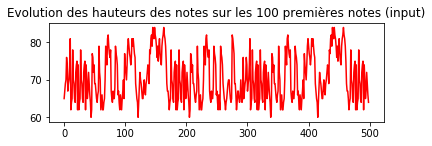

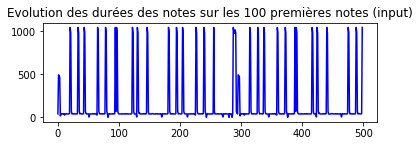

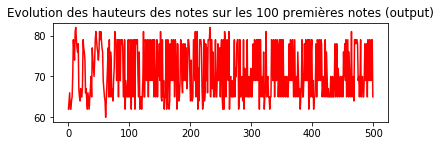

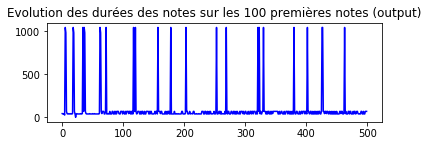

In [129]:
tabnote=[]
tabduree=[]

tabnoteout=[]
tabdureeout=[]

for i in range (1,500):
    tabnote.append(note[i])
    tabduree.append(duree[i])

plt.figure(1)
plt.subplot(211)
plt.plot(tabnote,'r')
plt.title("Evolution des hauteurs des notes sur les 100 premières notes (input)")
plt.figure(2)
plt.subplot(212)
plt.plot(tabduree,'b')
plt.title("Evolution des durées des notes sur les 100 premières notes (input)")

plt.show()

#plot des sorties :
i=0
for n in nw.output_text:
    if i<500:
        tabnoteout.append(n[0])
        i=i+1

i=0
for n in nw.output_text:
    if i<500:
        tabdureeout.append(n[1])
        i=i+1

plt.figure(3)
plt.subplot(211)
plt.plot(tabnoteout,'r')
plt.title("Evolution des hauteurs des notes sur les 100 premières notes (output)")
plt.figure(4)
plt.subplot(212)
plt.plot(tabdureeout,'b')
plt.title("Evolution des durées des notes sur les 100 premières notes (output)")

plt.show()


Nos sorties correspondent bien à ce qui est prédit en entrée (cf. graphiques)

### Quelques résultats précédemment obtenus

Nous avons commencé le travail de prédiction et génération en fournissant en entrée un unique fichier (midi-classique-flute/[Free-scores.com]_ali-choobdar-night-the-lotus-66972.midi)_.

Ceci nous a permis dans un premier temps de constater :
<ul><li> qu'en mode génération, nous parvenions bien à générer des notes avec des hauteurs et durées cohérentes avec les données d'entrée. Néanmoins, en lançant le fichier généré sur le logiciel <i>Musescose</i>, nous avons constaté que les durées réelles des notes à la lecture étaient bien inférieures à celles du fichier d'entrée. Nous avons donc modifié les paramètres 